In [2]:
import sys, pycbc
print(sys.executable)         # should be /home/ananthu/pycbc-venv/bin/python
print(pycbc.__version__)

/home/ananthu/pycbc-venv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


/home/ananthu/pycbc-venv/bin/python
2.9.0


In [3]:
import warnings
warnings.filterwarnings("ignore", "Swiglal-redir-stdio")


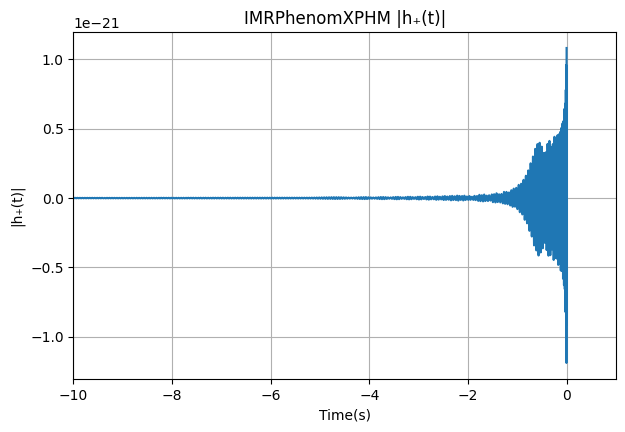

In [2]:
from pycbc.waveform import get_fd_waveform
import numpy as np
import matplotlib.pyplot as plt

params = dict(
    approximant="IMRPhenomXPHM",
    mass1=35, mass2=30,           # solar masses
    spin1x=0.0, spin1y=0.0, spin1z=0.5,
    spin2x=0.0, spin2y=0.0, spin2z=0.2,
    f_lower=20.0,                 # Hz
    delta_f=1/256.0,                # Hz resolution
    distance=500,                 # Mpc
    inclination=0.8,              # radians
)

hp, hc = get_fd_waveform(**params)


plt.figure(figsize=(7,4.5))
#plt.plot(hp.sample_frequencies.numpy(), hp.numpy())
hp.to_timeseries()
hp_td = hp.to_timeseries()

plt.plot(hp_td.sample_times, hp_td)
plt.xlim(-10,1)
plt.xlabel("Time(s)")
plt.ylabel("|h₊(t)|")
plt.title("IMRPhenomXPHM |h₊(t)|")
plt.grid(True, which="both")
plt.show()


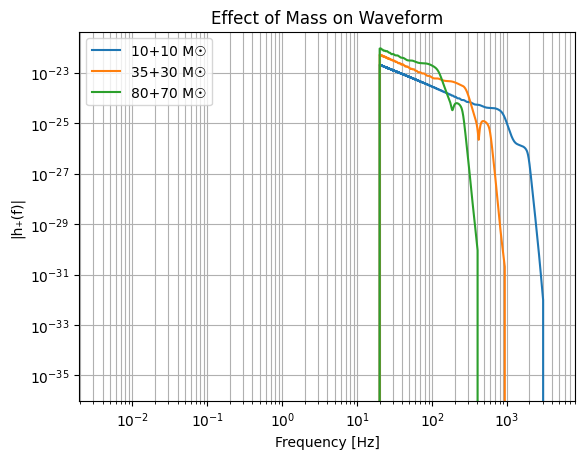

In [13]:
for m1, m2 in [(10,10), (35,30), (80,70)]:
    hp, hc = get_fd_waveform(approximant="IMRPhenomXPHM",
                             mass1=m1, mass2=m2,
                             f_lower=20.0, delta_f=1/256.0,
                             distance=500, inclination=0.8)
    plt.loglog(hp.sample_frequencies.numpy(), np.abs(hp.numpy()), label=f"{m1}+{m2} M☉")

plt.xlabel("Frequency [Hz]")
plt.ylabel("|h₊(f)|")
plt.title("Effect of Mass on Waveform")
plt.legend()
plt.grid(True, which="both")
plt.show()


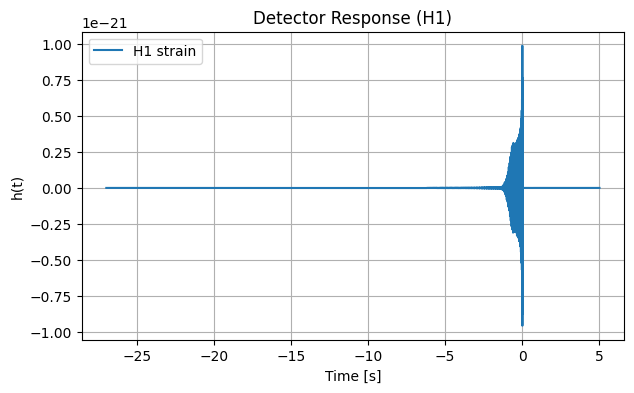

In [6]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform

# Create detector object
det = Detector("H1")  # options: 'H1', 'L1', 'V1', 'K1'

# Example: sky location (RA, Dec) and polarization
ra = 2.2      # radians
dec = -1.0    # radians
psi = 0.3     # polarization angle in radians

# Generate time-domain waveform
hp, hc = get_td_waveform(
    approximant="IMRPhenomXPHM",
    mass1=35, mass2=30,
    f_lower=20.0, delta_t=1/4096,
    distance=500,
    inclination=0.8
)

# Project onto detector
h_detector = det.project_wave(hp, hc, ra, dec, psi)

# Plot
plt.figure(figsize=(7,4))
plt.plot(h_detector.sample_times, h_detector, label="H1 strain")
plt.xlabel("Time [s]")
plt.ylabel("h(t)")
plt.title("Detector Response (H1)")
plt.grid(True)
plt.legend()
plt.show()


# SNR Calculation

In [19]:
from pycbc.psd import aLIGOZeroDetHighPower

In [20]:
h_fd = h_detector.to_frequencyseries()
freqs = h_fd.sample_frequencies
delta_f = h_fd.delta_f

In [21]:
flen = len(h_fd)
psd = aLIGOZeroDetHighPower(flen, delta_f, 20.0)

In [24]:
f_lower = 20.0
signal_power = np.abs(h_fd.numpy())**2
psd_np = psd.numpy()

# Mask only frequencies strictly greater than 20 Hz AND with valid PSD
valid = (freqs > f_lower) & (psd_np > 0)

print(f"Number of valid bins: {np.sum(valid)}")
print(f"First valid frequency: {freqs[valid][0]:.2f} Hz")

snr_squared = 4 * delta_f * np.sum(signal_power[valid] / psd_np[valid])
optimal_snr = np.sqrt(snr_squared)

print(f"Optimal SNR (manual) = {optimal_snr:.2f}")

Number of valid bins: 64928
First valid frequency: 20.02 Hz
Optimal SNR (manual) = 50.16
